In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(20,20)})
import random 
from datetime import datetime, timedelta
from bisect import *
from collections import defaultdict

%matplotlib inline

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_fault_data = pd.read_csv('/content/drive/My Drive/fault_data.csv')
df_scada_data = pd.read_csv('/content/drive/My Drive/scada_data.csv')

# Data Cleaning and Pre-processing

In [ ]:
df_fault_data.shape

(553, 3)

In [ ]:
df_scada_data.shape

(49027, 66)

In [ ]:
df_fault_data.head()

,DateTime,Time,Fault
0,2014-05-14 14:39:44,1.400096e+09,GF
1,2014-05-14 14:50:24,1.400097e+09,GF
2,2014-05-14 14:58:56,1.400098e+09,GF
3,2014-05-14 15:09:36,1.400098e+09,GF
4,2014-05-14 15:20:16,1.400099e+09,GF


In [ ]:
df_scada_data.head()

,DateTime,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,WEC: min. Power,WEC: ava. Nacel position including cable twisting,WEC: Operating Hours,WEC: Production kWh,WEC: Production minutes,WEC: ava. reactive Power,WEC: max. reactive Power,WEC: min. reactive Power,WEC: ava. available P from wind,WEC: ava. available P technical reasons,WEC: ava. Available P force majeure reasons,WEC: ava. Available P force external reasons,WEC: ava. blade angle A,Sys 1 inverter 1 cabinet temp.,Sys 1 inverter 2 cabinet temp.,Sys 1 inverter 3 cabinet temp.,Sys 1 inverter 4 cabinet temp.,Sys 1 inverter 5 cabinet temp.,Sys 1 inverter 6 cabinet temp.,Sys 1 inverter 7 cabinet temp.,Sys 2 inverter 1 cabinet temp.,Sys 2 inverter 2 cabinet temp.,Sys 2 inverter 3 cabinet temp.,Sys 2 inverter 4 cabinet temp.,Sys 2 inverter 5 cabinet temp.,Sys 2 inverter 6 cabinet temp.,Sys 2 inverter 7 cabinet temp.,Spinner temp.,Front bearing temp.,Rear bearing temp.,Pitch cabinet blade A temp.,Pitch cabinet blade B temp.,Pitch cabinet blade C temp.,Blade A temp.,Blade B temp.,Blade C temp.,Rotor temp. 1,Rotor temp. 2,Stator temp. 1,Stator temp. 2,Nacelle ambient temp. 1,Nacelle ambient temp. 2,Nacelle temp.,Nacelle cabinet temp.,Main carrier temp.,Rectifier cabinet temp.,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev
0,05-01-2014 00:00,1398920448,0,6.9,9.4,2.9,0.0,0.02,0.0,0,0,0,640,881,939053,6,0,0,0,838,0,838,838,91.959999,24,26,25,24,26,25,25,27,27,25,24,-14,0,-50,13,13,13,27,38,26,166,166,167,15,15,15,15,11,11,14,22,13,24,20,25,12,14,24,34,2501,25.272728,1.103713
1,05-01-2014 00:09,1398920960,0,5.3,8.9,1.6,0.0,0.01,0.0,0,0,0,640,881,939053,6,0,0,0,443,0,443,443,91.959999,24,26,25,24,26,25,25,27,27,25,24,-14,0,-50,13,13,13,27,38,26,166,166,167,15,15,15,15,11,11,13,21,13,24,20,25,12,14,24,34,2501,25.272728,1.103713
2,05-01-2014 00:20,1398921600,0,5.0,9.5,1.4,0.0,0.04,0.0,0,0,0,640,881,939053,6,0,0,0,525,0,525,525,91.940002,24,26,25,24,26,25,25,27,27,25,24,-14,0,-50,13,13,13,26,37,27,166,166,167,15,15,15,15,11,11,13,21,13,24,20,25,12,14,24,34,2501,25.272728,1.103713
3,05-01-2014 00:30,1398922240,0,4.4,8.3,1.3,0.0,0.08,0.0,0,0,0,641,881,939053,6,0,0,0,250,0,250,250,91.949997,24,26,25,24,26,25,25,27,27,25,24,-14,0,-50,13,13,13,26,33,31,166,166,167,15,15,15,15,11,11,13,20,13,23,21,25,12,14,24,34,2501,25.272728,1.103713
4,05-01-2014 00:39,1398922752,0,5.7,9.7,1.2,0.0,0.05,0.0,0,0,0,633,881,939053,6,0,0,0,549,0,549,549,91.940002,24,26,25,24,26,25,25,27,27,25,24,-14,0,-50,13,13,13,28,29,34,166,166,167,15,15,15,15,11,11,13,20,13,23,21,25,12,14,23,34,2501,25.272728,1.103713


In [ ]:
df_scada_data.columns

Index(['DateTime', 'Time', 'Error', 'WEC: ava. windspeed',
       'WEC: max. windspeed', 'WEC: min. windspeed', 'WEC: ava. Rotation',
       'WEC: max. Rotation', 'WEC: min. Rotation', 'WEC: ava. Power',
       'WEC: max. Power', 'WEC: min. Power',
       'WEC: ava. Nacel position including cable twisting',
       'WEC: Operating Hours', 'WEC: Production kWh',
       'WEC: Production minutes', 'WEC: ava. reactive Power',
       'WEC: max. reactive Power', 'WEC: min. reactive Power',
       'WEC: ava. available P from wind',
       'WEC: ava. available P technical reasons',
       'WEC: ava. Available P force majeure reasons',
       'WEC: ava. Available P force external reasons',
       'WEC: ava. blade angle A', 'Sys 1 inverter 1 cabinet temp.',
       'Sys 1 inverter 2 cabinet temp.', 'Sys 1 inverter 3 cabinet temp.',
       'Sys 1 inverter 4 cabinet temp.', 'Sys 1 inverter 5 cabinet temp.',
       'Sys 1 inverter 6 cabinet temp.', 'Sys 1 inverter 7 cabinet temp.',
       'Sys 2 inve

In [ ]:
df_scada_data.drop(['WEC: Production minutes', 'Pitch cabinet blade A temp.', 'Pitch cabinet blade B temp.',
       'Pitch cabinet blade C temp.', 'Main carrier temp.',
       'Rectifier cabinet temp.', ],axis=1,inplace=True)
df_scada_data.drop('WEC: max. windspeed',axis=1,inplace=True)
df_scada_data.drop('WEC: min. windspeed',axis=1,inplace=True)
df_scada_data.drop('WEC: max. Rotation',axis=1,inplace=True)
df_scada_data.drop('WEC: min. Rotation',axis=1,inplace=True)
df_scada_data.drop('WEC: max. Power',axis=1,inplace=True)
df_scada_data.drop('WEC: min. Power',axis=1,inplace=True)
df_scada_data.drop('WEC: Production kWh',axis=1,inplace=True)
df_scada_data.drop(['WEC: ava. reactive Power',
       'WEC: max. reactive Power', 'WEC: min. reactive Power',
       'WEC: ava. available P from wind',
       'WEC: ava. available P technical reasons',
       'WEC: ava. Available P force majeure reasons',
       'WEC: ava. Available P force external reasons'],axis=1,inplace=True)
df_scada_data.drop(['Sys 1 inverter 1 cabinet temp.',
       'Sys 1 inverter 2 cabinet temp.', 'Sys 1 inverter 3 cabinet temp.',
       'Sys 1 inverter 4 cabinet temp.', 'Sys 1 inverter 5 cabinet temp.',
       'Sys 1 inverter 6 cabinet temp.', 'Sys 1 inverter 7 cabinet temp.',
       'Sys 2 inverter 1 cabinet temp.', 'Sys 2 inverter 2 cabinet temp.',
       'Sys 2 inverter 3 cabinet temp.', 'Sys 2 inverter 4 cabinet temp.',
       'Sys 2 inverter 5 cabinet temp.', 'Sys 2 inverter 6 cabinet temp.',
       'Sys 2 inverter 7 cabinet temp.'],axis=1,inplace=True)
df_scada_data.drop([ 'Blade A temp.', 'Blade C temp.', 'Rotor temp. 2',
       'Stator temp. 2', 'Nacelle ambient temp. 1', 'Nacelle ambient temp. 2',
       'Nacelle cabinet temp.', 'RTU: ava. Setpoint 1',
       'Inverter averages', 'Inverter std dev'],axis=1,inplace=True)

In [ ]:
df_scada_data.columns

Index(['DateTime', 'Time', 'Error', 'WEC: ava. windspeed',
       'WEC: ava. Rotation', 'WEC: ava. Power',
       'WEC: ava. Nacel position including cable twisting',
       'WEC: Operating Hours', 'WEC: ava. blade angle A', 'Spinner temp.',
       'Front bearing temp.', 'Rear bearing temp.', 'Blade B temp.',
       'Rotor temp. 1', 'Stator temp. 1', 'Nacelle temp.',
       'Yaw inverter cabinet temp.', 'Fan inverter cabinet temp.',
       'Ambient temp.', 'Tower temp.', 'Control cabinet temp.',
       'Transformer temp.'],
      dtype='object')

In [ ]:
df_main = pd.merge(df_scada_data, df_fault_data, how='left')
df_main

,DateTime,Time,Error,WEC: ava. windspeed,WEC: ava. Rotation,WEC: ava. Power,WEC: ava. Nacel position including cable twisting,WEC: Operating Hours,WEC: ava. blade angle A,Spinner temp.,Front bearing temp.,Rear bearing temp.,Blade B temp.,Rotor temp. 1,Stator temp. 1,Nacelle temp.,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,Fault
0,05-01-2014 00:00,1398920448,0,6.9,0.00,0,640,881,91.959999,13,13,13,166,15,15,14,20,25,12,14,24,34,NaN
1,05-01-2014 00:09,1398920960,0,5.3,0.00,0,640,881,91.959999,13,13,13,166,15,15,13,20,25,12,14,24,34,NaN
2,05-01-2014 00:20,1398921600,0,5.0,0.00,0,640,881,91.940002,13,13,13,166,15,15,13,20,25,12,14,24,34,NaN
3,05-01-2014 00:30,1398922240,0,4.4,0.00,0,641,881,91.949997,13,13,13,166,15,15,13,21,25,12,14,24,34,NaN
4,05-01-2014 00:39,1398922752,0,5.7,0.00,0,633,881,91.940002,13,13,13,166,15,15,13,21,25,12,14,23,34,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49022,04-08-2015 23:20,1428553216,0,3.9,6.75,147,148,7884,1.000000,18,24,29,165,46,46,16,23,28,9,17,27,35,NaN
49023,04-08-2015 23:30,1428553856,0,3.9,6.64,128,148,7884,1.000000,18,24,29,165,46,46,16,23,28,9,17,27,35,NaN
49024,04-08-2015 23:39,1428554368,0,4.2,7.18,163,149,7884,1.000000,18,24,29,165,46,46,16,23,28,9,18,27,34,NaN
49025,04-08-2015 23:50,1428555008,0,4.1,7.02,160,151,7884,1.000000,18,24,30,165,46,46,16,23,28,9,17,27,34,NaN


In [ ]:
dict=pd.Series(df_fault_data.Fault.values,index=df_fault_data.Time).to_dict()

In [ ]:
len(dict)

446

In [ ]:
dict

{1400096384.0: 'GF',
 1400097024.0: 'GF',
 1400097536.0: 'GF',
 1400098176.0: 'GF',
 1400098816.0: 'GF',
 1400099456.0: 'GF',
 1401887360.0: 'MF',
 1401888000.0: 'MF',
 1401919232.0: 'MF',
 1402001408.0: 'MF',
 1402008064.0: 'FF',
 1402289408.0: 'AF',
 1402290048.0: 'MF',
 1402290560.0: 'MF',
 1402375808.0: 'AF',
 1402376448.0: 'MF',
 1402376960.0: 'MF',
 1402462208.0: 'AF',
 1402462848.0: 'MF',
 1402463360.0: 'MF',
 1402548608.0: 'AF',
 1402549248.0: 'MF',
 1402549760.0: 'MF',
 1402681856.0: 'FF',
 1403751040.0: 'AF',
 1403751552.0: 'MF',
 1403752192.0: 'MF',
 1404417024.0: 'AF',
 1404417536.0: 'MF',
 1404418176.0: 'MF',
 1405358976.0: 'FF',
 1405359616.0: 'FF',
 1405663744.0: 'FF',
 1405664384.0: 'FF',
 1405665024.0: 'FF',
 1405665536.0: 'FF',
 1405666176.0: 'EF',
 1405666816.0: 'EF',
 1405943424.0: 'AF',
 1405944064.0: 'AF',
 1405944576.0: 'AF',
 1405945216.0: 'AF',
 1406029824.0: 'AF',
 1406030336.0: 'AF',
 1406030976.0: 'AF',
 1407448192.0: 'AF',
 1407448832.0: 'AF',
 1407449344.0

In [ ]:
for time in dict:
    df_main.loc[df_main['Time']==time, 'Fault'] = dict[time]

In [ ]:
df_main['Fault']=df_main['Fault'].fillna("No Fault")
df_main

,DateTime,Time,Error,WEC: ava. windspeed,WEC: ava. Rotation,WEC: ava. Power,WEC: ava. Nacel position including cable twisting,WEC: Operating Hours,WEC: ava. blade angle A,Spinner temp.,Front bearing temp.,Rear bearing temp.,Blade B temp.,Rotor temp. 1,Stator temp. 1,Nacelle temp.,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,Fault
0,05-01-2014 00:00,1398920448,0,6.9,0.00,0,640,881,91.959999,13,13,13,166,15,15,14,20,25,12,14,24,34,No Fault
1,05-01-2014 00:09,1398920960,0,5.3,0.00,0,640,881,91.959999,13,13,13,166,15,15,13,20,25,12,14,24,34,No Fault
2,05-01-2014 00:20,1398921600,0,5.0,0.00,0,640,881,91.940002,13,13,13,166,15,15,13,20,25,12,14,24,34,No Fault
3,05-01-2014 00:30,1398922240,0,4.4,0.00,0,641,881,91.949997,13,13,13,166,15,15,13,21,25,12,14,24,34,No Fault
4,05-01-2014 00:39,1398922752,0,5.7,0.00,0,633,881,91.940002,13,13,13,166,15,15,13,21,25,12,14,23,34,No Fault
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49022,04-08-2015 23:20,1428553216,0,3.9,6.75,147,148,7884,1.000000,18,24,29,165,46,46,16,23,28,9,17,27,35,No Fault
49023,04-08-2015 23:30,1428553856,0,3.9,6.64,128,148,7884,1.000000,18,24,29,165,46,46,16,23,28,9,17,27,35,No Fault
49024,04-08-2015 23:39,1428554368,0,4.2,7.18,163,149,7884,1.000000,18,24,29,165,46,46,16,23,28,9,18,27,34,No Fault
49025,04-08-2015 23:50,1428555008,0,4.1,7.02,160,151,7884,1.000000,18,24,30,165,46,46,16,23,28,9,17,27,34,No Fault


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

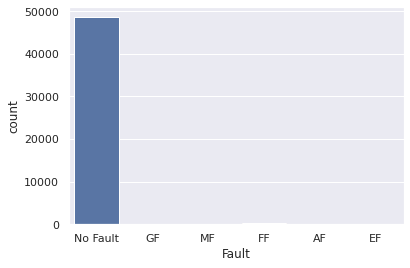

In [ ]:
sns.countplot(x='Fault',data=df_main)

In [ ]:
df_main.columns

Index(['DateTime', 'Time', 'Error', 'WEC: ava. windspeed',
       'WEC: ava. Rotation', 'WEC: ava. Power',
       'WEC: ava. Nacel position including cable twisting',
       'WEC: Operating Hours', 'WEC: ava. blade angle A', 'Spinner temp.',
       'Front bearing temp.', 'Rear bearing temp.', 'Blade B temp.',
       'Rotor temp. 1', 'Stator temp. 1', 'Nacelle temp.',
       'Yaw inverter cabinet temp.', 'Fan inverter cabinet temp.',
       'Ambient temp.', 'Tower temp.', 'Control cabinet temp.',
       'Transformer temp.', 'Fault'],
      dtype='object')

In [ ]:
df_main.drop('DateTime',axis=1,inplace=True)
df_main.drop('Time',axis=1,inplace=True)
df_main.drop('Error',axis=1,inplace=True)

In [ ]:
df_main.head()

,WEC: ava. windspeed,WEC: ava. Rotation,WEC: ava. Power,WEC: ava. Nacel position including cable twisting,WEC: Operating Hours,WEC: ava. blade angle A,Spinner temp.,Front bearing temp.,Rear bearing temp.,Blade B temp.,Rotor temp. 1,Stator temp. 1,Nacelle temp.,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,Fault
0,6.9,0.0,0,640,881,91.959999,13,13,13,166,15,15,14,20,25,12,14,24,34,No Fault
1,5.3,0.0,0,640,881,91.959999,13,13,13,166,15,15,13,20,25,12,14,24,34,No Fault
2,5.0,0.0,0,640,881,91.940002,13,13,13,166,15,15,13,20,25,12,14,24,34,No Fault
3,4.4,0.0,0,641,881,91.949997,13,13,13,166,15,15,13,21,25,12,14,24,34,No Fault
4,5.7,0.0,0,633,881,91.940002,13,13,13,166,15,15,13,21,25,12,14,23,34,No Fault


In [ ]:
X=df_main.drop('Fault',axis=1)
y=df_main['Fault']

In [ ]:
y

0        No Fault
1        No Fault
2        No Fault
3        No Fault
4        No Fault
           ...   
49022    No Fault
49023    No Fault
49024    No Fault
49025    No Fault
49026    No Fault
Name: Fault, Length: 49027, dtype: object

In [ ]:
X_training_features, X_testing_features, y_training_features, y_testing_features = train_test_split(X, y, test_size=0.1, random_state=12)

# Logistic Regression(Imbalanced Classes)

In [ ]:
log_reg=LogisticRegression(max_iter=1000,solver='saga')

In [ ]:
log_reg.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predictions=log_reg.predict(X_test)

In [ ]:
print(pd.crosstab(y_test,predictions))

col_0     FF  No Fault
Fault                 
AF         0        15
EF         0        19
FF         2        74
GF         0        14
MF         0         9
No Fault   6     14570


In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

          AF       0.00      0.00      0.00        11
          EF       0.00      0.00      0.00        14
          FF       0.17      0.08      0.11        51
          GF       0.00      0.00      0.00        10
          MF       0.00      0.00      0.00         5
    No Fault       0.99      1.00      0.99      9715

    accuracy                           0.99      9806
   macro avg       0.19      0.18      0.18      9806
weighted avg       0.98      0.99      0.99      9806



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
unique, count = np.unique(y_training_features, return_counts=True)
Y_train_dict_value_count = { k:v for (k,v) in zip(unique, count)}
Y_train_dict_value_count

{'AF': 43, 'EF': 72, 'FF': 230, 'GF': 41, 'MF': 20, 'No Fault': 43718}

# SMOTE

In [ ]:
X_train_res,X_test_res,y_train_res,y_test_res= train_test_split(X_training_features, y_training_features, test_size=0.2, random_state=12)

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
sm = SMOTE(random_state=12)
final_x_train_res, final_y_train_res = sm.fit_sample(X_train_res, y_train_res)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
unique, count = np.unique(final_y_train_res, return_counts=True)
y_train_smote_value_count = { k:v for (k,v) in zip(unique, count)}
y_train_smote_value_count

{'AF': 34980,
 'EF': 34980,
 'FF': 34980,
 'GF': 34980,
 'MF': 34980,
 'No Fault': 34980}

# Logistic Regression After SMOTE

In [ ]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
log_reg_smote=LogisticRegression(max_iter=1000)

In [ ]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()), #Step1 - normalize data
    ('clf', LogisticRegression(max_iter=1000)) #step2 - classifier
])
pipeline.steps

[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('clf',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=1000,
                     multi_class='auto', n_jobs=None, penalty='l2',
                     random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=False))]

In [ ]:
from sklearn.model_selection import cross_validate

pipeline.fit(final_x_train_res,final_y_train_res)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
predictions=pipeline.predict(X_test_res)
print(pd.crosstab(y_test_res,predictions))
print(classification_report(y_test_res,predictions))

col_0       AF   EF   FF  GF   MF  No Fault
Fault                                      
AF           6    0    0   0    2         2
EF           0   12    2   0    0         0
FF           1    9   40   0    0         4
GF           0    0    0   7    0         0
MF           0    0    0   0    1         1
No Fault  1177  451  613  10  655      5832
              precision    recall  f1-score   support

          AF       0.01      0.60      0.01        10
          EF       0.03      0.86      0.05        14
          FF       0.06      0.74      0.11        54
          GF       0.41      1.00      0.58         7
          MF       0.00      0.50      0.00         2
    No Fault       1.00      0.67      0.80      8738

    accuracy                           0.67      8825
   macro avg       0.25      0.73      0.26      8825
weighted avg       0.99      0.67      0.79      8825



In [ ]:
predictions=pipeline.predict(X_testing_features)
print(pd.crosstab(y_testing_features,predictions))
print(classification_report(y_testing_features,predictions))

col_0      AF   EF   FF  GF   MF  No Fault
Fault                                     
AF          6    0    0   0    0         1
EF          0    6    1   0    0         0
FF          0    3   15   0    1         5
GF          0    0    0   2    0         0
No Fault  654  253  334   8  348      3266
              precision    recall  f1-score   support

          AF       0.01      0.86      0.02         7
          EF       0.02      0.86      0.04         7
          FF       0.04      0.62      0.08        24
          GF       0.20      1.00      0.33         2
          MF       0.00      0.00      0.00         0
    No Fault       1.00      0.67      0.80      4863

    accuracy                           0.67      4903
   macro avg       0.21      0.67      0.21      4903
weighted avg       0.99      0.67      0.80      4903



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC())
])

In [ ]:
pipeline.fit(final_x_train_res,final_y_train_res)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [ ]:
predictions=pipeline.predict(X_test_res)
print(pd.crosstab(y_test_res,predictions))
print(classification_report(y_test_res,predictions))

col_0      AF  EF   FF  GF  MF  No Fault
Fault                                   
AF          7   0    0   0   2         1
EF          0   9    4   0   0         1
FF          0   4   50   0   0         0
GF          0   0    0   7   0         0
MF          2   0    0   0   0         0
No Fault  199  99  153   2  69      8216
              precision    recall  f1-score   support

          AF       0.03      0.70      0.06        10
          EF       0.08      0.64      0.14        14
          FF       0.24      0.93      0.38        54
          GF       0.78      1.00      0.88         7
          MF       0.00      0.00      0.00         2
    No Fault       1.00      0.94      0.97      8738

    accuracy                           0.94      8825
   macro avg       0.36      0.70      0.41      8825
weighted avg       0.99      0.94      0.96      8825



In [ ]:
predictions=pipeline.predict(X_testing_features)
print(pd.crosstab(y_testing_features,predictions))
print(classification_report(y_testing_features,predictions))

col_0      AF  EF   FF  GF  MF  No Fault
Fault                                   
AF          6   0    0   0   0         1
EF          0   6    1   0   0         0
FF          0   1   22   0   0         1
GF          0   0    0   2   0         0
No Fault  131  63  101   3  44      4521
              precision    recall  f1-score   support

          AF       0.04      0.86      0.08         7
          EF       0.09      0.86      0.16         7
          FF       0.18      0.92      0.30        24
          GF       0.40      1.00      0.57         2
          MF       0.00      0.00      0.00         0
    No Fault       1.00      0.93      0.96      4863

    accuracy                           0.93      4903
   macro avg       0.28      0.76      0.35      4903
weighted avg       0.99      0.93      0.96      4903



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=5))
])

In [ ]:
pipeline.fit(final_x_train_res,final_y_train_res)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

In [ ]:
predictions=pipeline.predict(X_test_res)
print(pd.crosstab(y_test_res,predictions))
print(classification_report(y_test_res,predictions))

col_0     AF  EF  FF  GF  MF  No Fault
Fault                                 
AF         5   0   1   0   3         1
EF         0   5   4   0   0         5
FF         0   3  41   0   0        10
GF         0   0   0   7   0         0
MF         2   0   0   0   0         0
No Fault  45  17  63   3  15      8595
              precision    recall  f1-score   support

          AF       0.10      0.50      0.16        10
          EF       0.20      0.36      0.26        14
          FF       0.38      0.76      0.50        54
          GF       0.70      1.00      0.82         7
          MF       0.00      0.00      0.00         2
    No Fault       1.00      0.98      0.99      8738

    accuracy                           0.98      8825
   macro avg       0.40      0.60      0.46      8825
weighted avg       0.99      0.98      0.99      8825



In [ ]:
predictions=pipeline.predict(X_testing_features)
print(pd.crosstab(y_testing_features,predictions))
print(classification_report(y_testing_features,predictions))

col_0     AF  EF  FF  GF  MF  No Fault
Fault                                 
AF         5   0   0   0   0         2
EF         0   5   1   0   0         1
FF         0   1  20   0   0         3
GF         0   0   0   2   0         0
No Fault  31  25  42   3   5      4757
              precision    recall  f1-score   support

          AF       0.14      0.71      0.23         7
          EF       0.16      0.71      0.26         7
          FF       0.32      0.83      0.46        24
          GF       0.40      1.00      0.57         2
          MF       0.00      0.00      0.00         0
    No Fault       1.00      0.98      0.99      4863

    accuracy                           0.98      4903
   macro avg       0.34      0.71      0.42      4903
weighted avg       0.99      0.98      0.98      4903



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB() 

In [ ]:
gnb.fit(final_x_train_res,final_y_train_res)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
predictions=gnb.predict(X_test_res)
print(pd.crosstab(y_test_res,predictions))
print(classification_report(y_test_res,predictions))

col_0       AF   EF    FF   GF   MF  No Fault
Fault                                        
AF           9    0     1    0    0         0
EF           0   13     1    0    0         0
FF           3   17    29    4    0         1
GF           0    0     0    7    0         0
MF           2    0     0    0    0         0
No Fault  2674  584  2388  148  990      1954
              precision    recall  f1-score   support

          AF       0.00      0.90      0.01        10
          EF       0.02      0.93      0.04        14
          FF       0.01      0.54      0.02        54
          GF       0.04      1.00      0.08         7
          MF       0.00      0.00      0.00         2
    No Fault       1.00      0.22      0.37      8738

    accuracy                           0.23      8825
   macro avg       0.18      0.60      0.09      8825
weighted avg       0.99      0.23      0.36      8825



In [ ]:
predictions=gnb.predict(X_testing_features)
print(pd.crosstab(y_testing_features,predictions))
print(classification_report(y_testing_features,predictions))

col_0       AF   EF    FF  GF   MF  No Fault
Fault                                       
AF           5    0     1   0    0         1
EF           1    6     0   0    0         0
FF           1    4    19   0    0         0
GF           0    0     0   2    0         0
No Fault  1508  344  1311  80  571      1049
              precision    recall  f1-score   support

          AF       0.00      0.71      0.01         7
          EF       0.02      0.86      0.03         7
          FF       0.01      0.79      0.03        24
          GF       0.02      1.00      0.05         2
          MF       0.00      0.00      0.00         0
    No Fault       1.00      0.22      0.35      4863

    accuracy                           0.22      4903
   macro avg       0.18      0.60      0.08      4903
weighted avg       0.99      0.22      0.35      4903



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=100)

rf.fit(final_x_train_res,final_y_train_res)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
predictions=rf.predict(X_test_res)
print(pd.crosstab(y_test_res,predictions))
print(classification_report(y_test_res,predictions))

col_0     AF  EF  FF  GF  MF  No Fault
Fault                                 
AF         2   0   0   0   1         7
EF         0   2   3   0   0         9
FF         0   2  37   0   0        15
GF         0   0   0   7   0         0
MF         0   0   0   0   0         2
No Fault   3   8  17   0   2      8708
              precision    recall  f1-score   support

          AF       0.40      0.20      0.27        10
          EF       0.17      0.14      0.15        14
          FF       0.65      0.69      0.67        54
          GF       1.00      1.00      1.00         7
          MF       0.00      0.00      0.00         2
    No Fault       1.00      1.00      1.00      8738

    accuracy                           0.99      8825
   macro avg       0.54      0.50      0.51      8825
weighted avg       0.99      0.99      0.99      8825



In [ ]:
predictions=rf.predict(X_testing_features)
print(pd.crosstab(y_testing_features,predictions))
print(classification_report(y_testing_features,predictions))

col_0     AF  EF  FF  GF  No Fault
Fault                             
AF         2   0   0   0         5
EF         0   2   1   0         4
FF         0   0  20   0         4
GF         0   0   0   2         0
No Fault   0   5  10   1      4847
              precision    recall  f1-score   support

          AF       1.00      0.29      0.44         7
          EF       0.29      0.29      0.29         7
          FF       0.65      0.83      0.73        24
          GF       0.67      1.00      0.80         2
    No Fault       1.00      1.00      1.00      4863

    accuracy                           0.99      4903
   macro avg       0.72      0.68      0.65      4903
weighted avg       0.99      0.99      0.99      4903



In [ ]:
cf_matrix = confusion_matrix(y_testing_features, predictions)
print(cf_matrix)

[[   2    0    0    0    5]
 [   0    2    1    0    4]
 [   0    0   20    0    4]
 [   0    0    0    2    0]
 [   0    5   10    1 4847]]


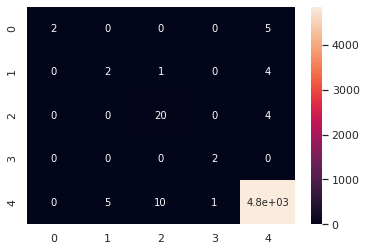

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

# Gradient Boosting

In [ ]:
import xgboost 
xgb = xgboost.XGBClassifier() 
xgb.fit(final_x_train_res, final_y_train_res) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
predictions=xgb.predict(X_test_res.values)
print(pd.crosstab(y_test_res,predictions))
print(classification_report(y_test_res,predictions))

col_0      AF  EF   FF  GF  MF  No Fault
Fault                                   
AF          6   0    1   0   1         2
EF          0  10    4   0   0         0
FF          0   2   48   0   0         4
GF          0   0    0   7   0         0
MF          0   0    0   0   0         2
No Fault  183  74  136   2  54      8289
              precision    recall  f1-score   support

          AF       0.03      0.60      0.06        10
          EF       0.12      0.71      0.20        14
          FF       0.25      0.89      0.40        54
          GF       0.78      1.00      0.88         7
          MF       0.00      0.00      0.00         2
    No Fault       1.00      0.95      0.97      8738

    accuracy                           0.95      8825
   macro avg       0.36      0.69      0.42      8825
weighted avg       0.99      0.95      0.97      8825



In [ ]:
predictions=xgb.predict(X_testing_features.values)
print(pd.crosstab(y_testing_features,predictions))
print(classification_report(y_testing_features,predictions))

col_0      AF  EF  FF  GF  MF  No Fault
Fault                                  
AF          4   0   0   0   0         3
EF          0   5   2   0   0         0
FF          0   0  22   0   0         2
GF          0   0   0   2   0         0
No Fault  134  46  90   4  41      4548
              precision    recall  f1-score   support

          AF       0.03      0.57      0.06         7
          EF       0.10      0.71      0.17         7
          FF       0.19      0.92      0.32        24
          GF       0.33      1.00      0.50         2
          MF       0.00      0.00      0.00         0
    No Fault       1.00      0.94      0.97      4863

    accuracy                           0.93      4903
   macro avg       0.28      0.69      0.34      4903
weighted avg       0.99      0.93      0.96      4903



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cf_matrix = confusion_matrix(y_testing_features, predictions)
print(cf_matrix)

[[   4    0    0    0    0    3]
 [   0    5    2    0    0    0]
 [   0    0   22    0    0    2]
 [   0    0    0    2    0    0]
 [   0    0    0    0    0    0]
 [ 134   46   90    4   41 4548]]


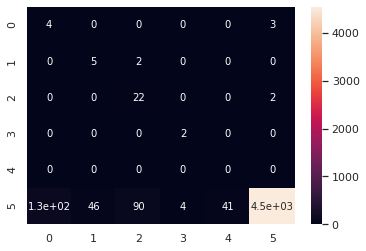

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)

dt.fit(final_x_train_res,final_y_train_res)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
predictions=dt.predict(X_test_res)
print(pd.crosstab(y_test_res,predictions))
print(classification_report(y_test_res,predictions))

col_0     AF  EF  FF  GF  MF  No Fault
Fault                                 
AF         1   0   0   0   2         7
EF         0   1   0   0   0        13
FF         0   1  35   0   0        18
GF         0   0   0   6   0         1
MF         1   0   0   0   0         1
No Fault  23  16  35   0   6      8658
              precision    recall  f1-score   support

          AF       0.04      0.10      0.06        10
          EF       0.06      0.07      0.06        14
          FF       0.50      0.65      0.56        54
          GF       1.00      0.86      0.92         7
          MF       0.00      0.00      0.00         2
    No Fault       1.00      0.99      0.99      8738

    accuracy                           0.99      8825
   macro avg       0.43      0.44      0.43      8825
weighted avg       0.99      0.99      0.99      8825



In [ ]:
predictions=dt.predict(X_testing_features)
print(pd.crosstab(y_testing_features,predictions))
print(classification_report(y_testing_features,predictions))

col_0     AF  EF  FF  GF  MF  No Fault
Fault                                 
AF         3   0   0   0   0         4
EF         0   1   0   0   0         6
FF         0   1  17   0   0         6
GF         0   0   0   2   0         0
No Fault  12   6  19   2  11      4813
              precision    recall  f1-score   support

          AF       0.20      0.43      0.27         7
          EF       0.12      0.14      0.13         7
          FF       0.47      0.71      0.57        24
          GF       0.50      1.00      0.67         2
          MF       0.00      0.00      0.00         0
    No Fault       1.00      0.99      0.99      4863

    accuracy                           0.99      4903
   macro avg       0.38      0.54      0.44      4903
weighted avg       0.99      0.99      0.99      4903



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cf_matrix = confusion_matrix(y_testing_features, predictions)
print(cf_matrix)

[[   3    0    0    0    0    4]
 [   0    1    0    0    0    6]
 [   0    1   17    0    0    6]
 [   0    0    0    2    0    0]
 [   0    0    0    0    0    0]
 [  12    6   19    2   11 4813]]


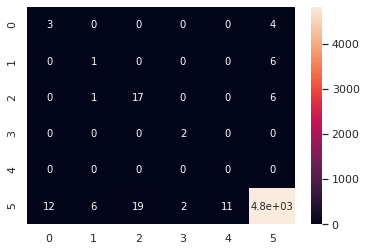

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

# Random Forest HyperParameter Tuning

In [ ]:
del dict

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf2 = RandomForestClassifier()

In [ ]:
n_estimators = [10, 100, 500]
max_depth = [3,5]

In [ ]:
grid = dict(n_estimators=n_estimators,max_depth=max_depth)
grid_search = GridSearchCV(rf2, grid, n_jobs=-1, scoring='accuracy',error_score=0)

In [ ]:
grid_result = grid_search.fit(final_x_train_res, final_y_train_res)

KeyboardInterrupt: ignored

In [ ]:
grid_result.best_params_

# Neural networks

In [ ]:
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import  Dense, Flatten
from keras.utils import normalize, to_categorical

In [ ]:
print(final_x_train_res.shape)
print(final_y_train_res.shape)
print(X_test_res.shape)
print(y_test_res.shape)


(209880, 19)
(209880,)
(8825, 19)
(8825,)


In [ ]:
nn_final_x_train_res = normalize(final_x_train_res, axis=1)
nn_X_test = normalize(X_test_res, axis=1)

In [ ]:
activation = 'sigmoid'
model = Sequential()
model.add(BatchNormalization())

model.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())

model.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())

model.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization()) 

model.add(Flatten())
model.add(Dense(128, activation = activation, kernel_initializer = 'he_uniform'))
model.add(Dense(10, activation = 'softmax'))